In [ ]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import torch

from OkadaTorch import OkadaWrapper
okada = OkadaWrapper()

In [ ]:
# domain
lon_min, lon_max = 142, 148
lat_min, lat_max = 37, 43
dlon, dlat = 0.05, 0.05
nlon, nlat = int((lon_max-lon_min)/dlon)+1, int((lat_max-lat_min)/dlon)+1


# coordinate transformation
pj_tmerc = f"+proj=tmerc +lon_0={(lon_min+lon_max)/2} +k=1.00010001 +ellps=WGS84 +datum=WGS84 +no_defs"
pj_latlong = "+proj=latlong +ellps=WGS84 +datum=WGS84 +no_defs"
ll2xy = pyproj.Transformer.from_proj(pj_latlong, pj_tmerc, always_xy=True)

lon = np.linspace(lon_min, lon_max, nlon)
lat = np.linspace(lat_min, lat_max, nlat)
Lon, Lat = np.meshgrid(lon, lat)
x, y = ll2xy.transform(Lon, Lat)
X = torch.from_numpy(x/1e3) # km
Y = torch.from_numpy(y/1e3) # km

z = np.zeros_like(x)
Z = torch.from_numpy(z)


# source parameters
lat_ref = 40.2224
lon_ref = 144.8678
x_ref, y_ref = ll2xy.transform(lon_ref, lat_ref)


# specify `requires_grad=True`
x_ref = torch.tensor(x_ref/1e3, requires_grad=True) # km
y_ref = torch.tensor(y_ref/1e3, requires_grad=True) # km
depth = torch.tensor(0.1, requires_grad=True) # km
length = torch.tensor(218.0, requires_grad=True) # km
width = torch.tensor(46.0, requires_grad=True) # km
dip = torch.tensor(60.0, requires_grad=True)
strike = torch.tensor(189.0, requires_grad=True)
rake = torch.tensor(270.0, requires_grad=True)
slip = torch.tensor(5.62, requires_grad=True)

In [11]:
coords = {
    "x": X,
    "y": Y,
    "z": Z
}
params = {
    "x_ref": x_ref,
    "y_ref": y_ref,
    "depth": depth,
    "length": length,
    "width": width,
    "strike": strike,
    "dip": dip,
    "rake": rake,
    "slip": slip
}

# Gradient of `ux`, `uy` and `uz` with respect to `x`, `y` and `z`

Note: In the following, `uij` means $\dfrac{\partial u_i}{\partial x_j}$

In [ ]:
# Analytical solution
ux, uy, uz, uxx, uyx, uzx, uxy, uyy, uzy, uxz, uyz, uzz = okada.compute(
    coords, params, compute_strain=True, is_degree=True
)

# by using AD
UXX, UYX, UZX = okada.gradient(coords, params, arg="x", compute_strain=False, is_degree=True)
UXY, UYY, UZY = okada.gradient(coords, params, arg="y", compute_strain=False, is_degree=True)
UXZ, UYZ, UZZ = okada.gradient(coords, params, arg="z", compute_strain=False, is_degree=True)

In [ ]:
# errors are very small
print(torch.abs(UXX-uxx).max())
print(torch.abs(UYX-uyx).max())
print(torch.abs(UZX-uzx).max())
print(torch.abs(UXY-uxy).max())
print(torch.abs(UYY-uyy).max())
print(torch.abs(UZY-uzy).max())
print(torch.abs(UXZ-uxz).max())
print(torch.abs(UYZ-uyz).max())
print(torch.abs(UZZ-uzz).max())

tensor(1.5750e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2938e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(2.7637e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(7.8177e-09, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.5505e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(4.3972e-09, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.7228e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.7533e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(6.6367e-09, dtype=torch.float64, grad_fn=<MaxBackward1>)


# Gradient of `uz` with respect to parameters

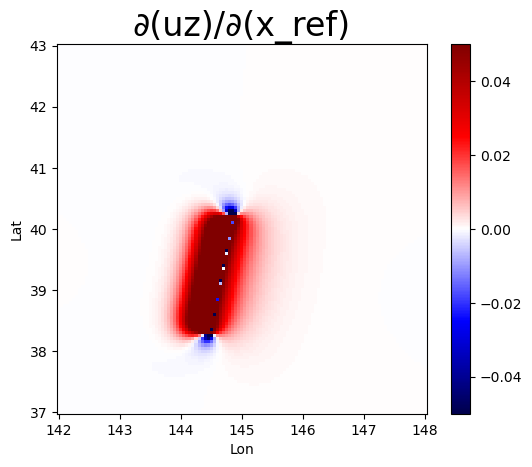

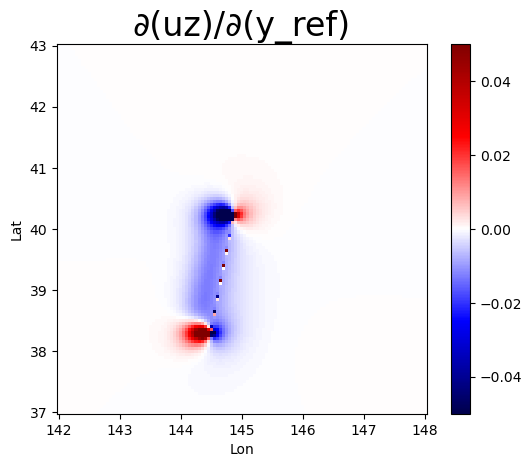

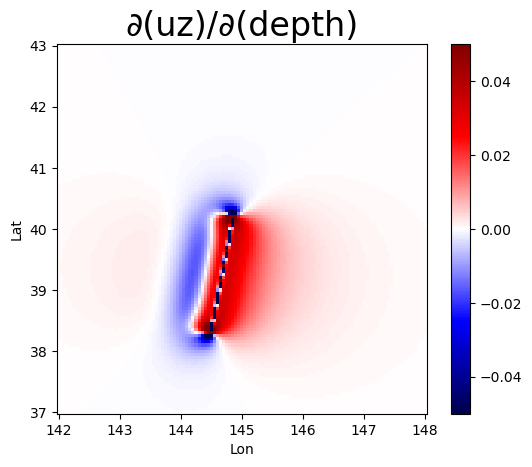

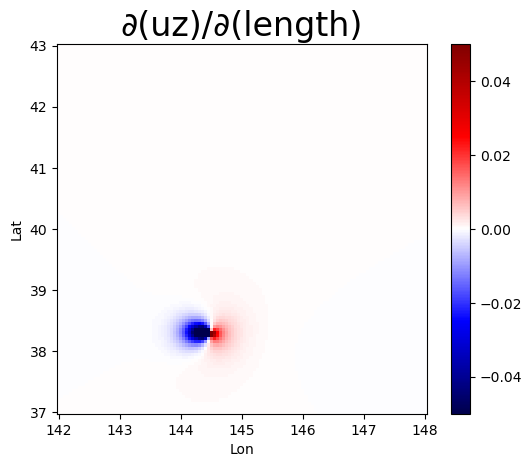

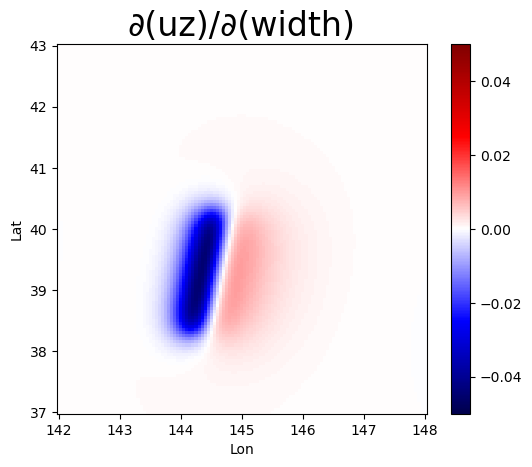

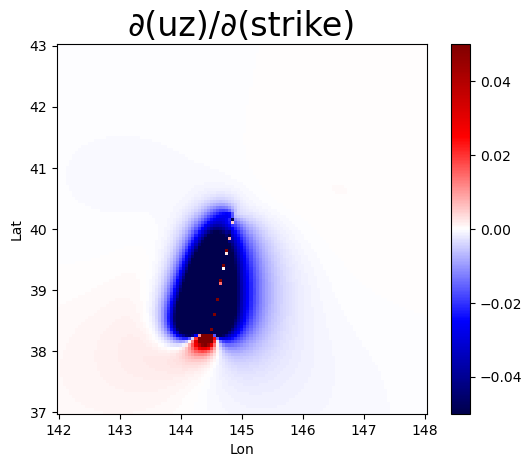

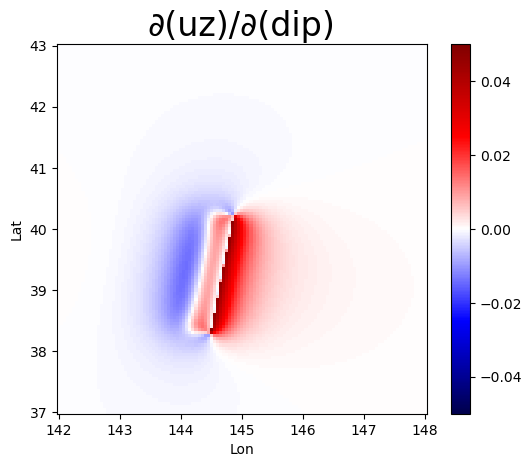

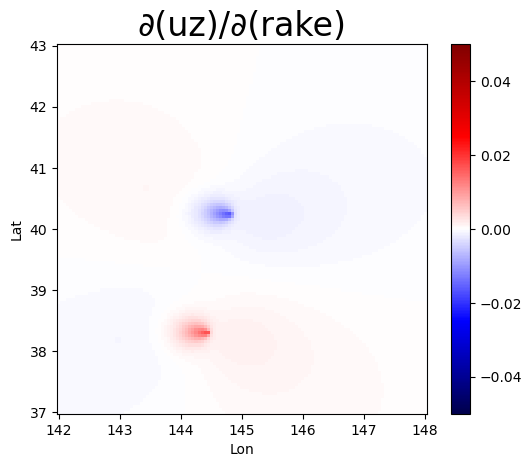

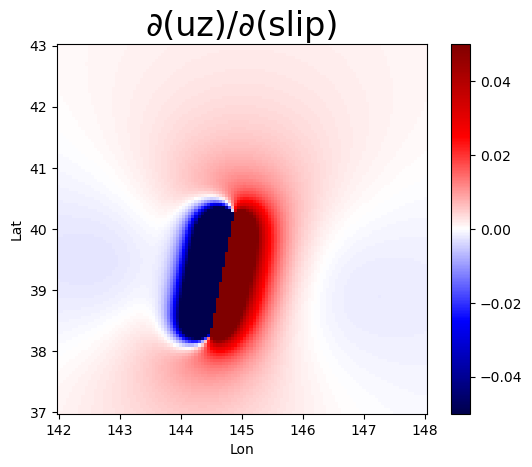

In [ ]:
for i, var in enumerate(list(params)):

    _, _, duz = okada.gradient(coords, params, arg=var, compute_strain=False, is_degree=True)

    fig, ax = plt.subplots()
    im = ax.pcolormesh(Lon, Lat, duz.detach().numpy(), cmap="seismic", vmin=-0.05, vmax=0.05)
    ax.set_aspect("equal")
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")
    ax.set_title(f"∂(uz)/∂({var})", fontsize=24)
    fig.colorbar(im)
    fig.show()